# Fit Halo Mass from a Shear Catalog: Redshift distribution of source galaxies

_the LSST-DESC CLMM team_


This notebook demonstrates how to use `clmm` to estimate a WL halo mass from observations of a galaxy cluster when source galaxies follow a given distribution (especially Chang. (2013) implemented in clmm). It uses several functionalities of the support `mock_data` module to produce datasets of increasing complexity. 

## Setup

First, we import some standard packages.

In [1]:
import sys
sys.path.append('/home/payernco/CLMM/examples/support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
from numpy import random
from sampler import fitters
from scipy.integrate import quad
plt.rcParams['font.family']=['gothambook','gotham','gotham-book','serif']

import cluster_toolkit as ct

clmm.__version__

'0.3.0'

Next, we import `clmm`'s core modules.

In [2]:
import clmm.polaraveraging as pa
import clmm.galaxycluster as gc
import clmm.modeling as modeling
from clmm.modeling import angular_diameter_dist_a1a2

from astropy import units

We then import a support modules for a specific data sets.
`clmm` includes support modules that enable the user to generate mock data in a format compatible with `clmm`.

In [3]:
import mock_data as mock

## Making mock data

For reproducibility:

In [4]:
np.random.seed(11)

To create mock data, we need to define a true cosmology, which is currently done with [`astropy`'s cosmology library](http://docs.astropy.org/en/stable/cosmology/index.html).

In [5]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)

We define the Chang. (2013) redshift distribution of galaxies:

$$
N(z) \propto z^\alpha\exp\left(-\left[\frac{z}{z_0}\right]^\beta\right)
$$

where parameters are chosen $\alpha, \beta, z_0$ = $1.24, 1.01, 0.51$.

In [6]:
def Chang(z): #Chang distribution of source redshift
    a = 1.24
    b = 1.01
    z_0 = 0.51
    return np.exp(-(z/z_0)**b)*z**a
zinf = 20
norm = quad(Chang, 0, zinf)[0]

We now set some parameters for a mock galaxy cluster:

In [7]:
cluster_m = 1.e15
logm = np.log(cluster_m)/np.log(10)
concentration = 4
cluster_ra = 0.
cluster_dec = 0.
cluster_z = 0.4
sigma = 30 # number of galaxies per arcmin^2
Delta = 200

In [8]:
norm = quad(Chang,0,zinf)[0]
ngals = 15000
print('The number of generated galaxies = ' + str(ngals))

The number of generated galaxies = 15000


Then we use the `mock_data` support module to generate 3 galaxy catalogs:
- `ideal_data`: galaxies distributed according to the Chang et al. (2013) redshift distribution.
- `noisy_data`: `ideal_data` + photoz errors + shape noise

(Galaxies have a minimum redshift defined as $z_{cluster} + 0.1$)

In [9]:
ideal_data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, ngals, Delta,'chang13', zsrc_min = cluster_z + 0.1)
noisy_data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, ngals, Delta,'chang13', zsrc_min = cluster_z + 0.1,
                                  shapenoise=0.05, 
                                  photoz_sigma_unscaled=0.05)

The galaxy catalogs are converted to a `clmm.GalaxyCluster` object and may be saved for later use.

In [10]:
cluster_id = "CL_ideal"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                                  cluster_z, ideal_data)
gc_object.save('ideal_GC.pkl')

cluster_id = "CL_noisy"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                                   cluster_z, noisy_data)
gc_object.save('noisy_GC.pkl')

Any saved clmm.GalaxyCluster object may be read in for analysis.

In [11]:
cl_ideal = clmm.load_cluster('ideal_GC.pkl') # background galaxies distributed according to Chang et al. (2013)
cl_noisy = clmm.load_cluster('noisy_GC.pkl') # Chang et al. (2013) + shapenoise + photozerror

# Deriving observables

# Computing shear

`clmm.polaraveraging.compute_shear` calculates the tangential and cross shears for each source galaxy in the cluster.

In [12]:
theta1, g_t1, g_x1 = cl_ideal.compute_shear(geometry="flat")
theta2, g_t2, g_x2 = cl_noisy.compute_shear(geometry="flat")

# Radially binning the data

In [13]:
bin_edges = pa.make_bins(0.2, 4, 15, method='evenlog10width')

`clmm.polaraveraging.make_shear_profile` evaluates the average shear of the galaxy catalog in bins of radius.

In [14]:
profile_ideal = cl_ideal.make_shear_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo, gal_ids_in_bins=True)
profile_noisy = cl_noisy.make_shear_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo, gal_ids_in_bins=True)

After running `clmm.polaraveraging.make_shear_profile` on a `clmm.GalaxyCluster object`, the object acquires the `clmm.GalaxyCluster.profile` attribute.

# Source galaxy redshift distribution

Redshift of galaxies generated by mock data are distributed following the Chang. (2013) Redshift distribution.

In [15]:
z_source = np.linspace(cluster_z + 0.1,5,100)
norm = quad(Chang, cluster_z + 0.1, 20)[0]
Chang_distribution = Chang(z_source)/norm

(0, 5)

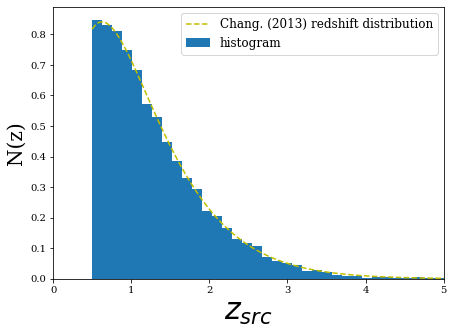

In [16]:
plt.figure(figsize=(7,5))
plt.hist(cl_ideal.galcat['z'], density = True, bins = 50, label='histogram')
plt.plot(z_source, Chang_distribution, '--y', label='Chang. (2013) redshift distribution')
plt.xlabel(r'$z_{src}$', fontsize = 30)
plt.ylabel(r'N(z)', fontsize = 20)
plt.legend(fontsize=12)
plt.xlim(0,5)

## Create the halo model.

The reduced tangential shear for source galaxies at a given redshift $g_t(\theta, z_s)$ is returned by the fucntion below:

In [17]:
def predict_reduced_tangential_shear(r, logm, z_src):
    m = 10.**logm
    gt_model = clmm.predict_reduced_tangential_shear(r*cosmo.h,
                                                         m, concentration,
                                                         cluster_z, z_src, cosmo,
                                                         delta_mdef=200,
                                                         halo_profile_model='nfw')    
    return gt_model

The fit of Halo mass from galaxy catalog must take account of redshift distribution of source galaxies, where $\langle g_t(\theta, z_s)\rangle \neq g_t(\theta, \langle z_s \rangle$). The reduced tangential shear that corresponds to a continuous distribution of source galaxy redshift $N(z)$ can be expressed as the following integral, as an average on $N(z)$:

$$
g_t(\theta) = \langle g_t(\theta, z_s)\rangle_{z_{cluster}} = \int_{z_{cluster}}^{+\infty}dz_sN(z_s)g_t(\theta, z_s)
$$

We can built a model based on data, such that: 

$$
g_t(\theta) = \frac{1}{N(\theta)}\sum\limits_{i = 1}^{N(\theta)}g_t(\theta, z_i)\hspace{1cm}\mbox{where}\hspace{1cm}\ N(\theta) := i-\mbox{th galaxies with}\  \theta_i \in [\theta-  \Delta\theta/2,  \theta + \Delta\theta/2[
$$

where $N(\theta)$ is the number of galaxies wih radius $\theta_i$ such that $\theta_i \in [\theta - \Delta\theta/2, \theta + \Delta\theta/2[$. The interval $[\theta - \Delta\theta/2, \theta + \Delta\theta/2[$ is provided above by radially binning the data with `compute_shear`.

This data-based model almost equals to reduced tangential shear estimated calculated by `compute_shear` when generated galaxies have no shape-noise, such that each ellipticities at redshift $z_i$ and angular distance $\theta_i$ is equals to reduced shear at $\theta_i$ for source redshift $z_i$ $g(\theta_i, z_i)$. Only remains a difference due to the choice $g_t(\theta_i, z_i)\rightarrow g_t(\theta, z_i)$.

In [18]:
def predict_reduced_tangential_shear_Chang( radius , logm , data , catalog , profile ): 
    m = 10**logm
    gt_model = []
    for i in range(len(radius)):
        
        r = profile['radius'][i]
        galist = profile['gal_id'][i]
        z = catalog.galcat['z'][galist]
        shear = clmm.predict_reduced_tangential_shear(r*cosmo.h,
                                                                         m, concentration,
                                                                         cluster_z, z, cosmo,                                                          delta_mdef=200,
                                                                         halo_profile_model='nfw')
        gt_model.append(np.mean(shear))
        
    return gt_model

We plot the reduced tangential shear estimated with `compute_shear` for ideal and noisy data (shape-noise plus redshift error) and associated data-based model `predict_reduced_tangential_shear_Chang`.

In [19]:
r = profile_ideal['radius']
z_average = np.mean(profile_ideal['z'])
print(z_average)
gt_model = predict_reduced_tangential_shear(r, logm, z_average)
gt_model_ideal = predict_reduced_tangential_shear_Chang(r,logm, ideal_data, cl_ideal, profile_ideal)
gt_model_noisy = predict_reduced_tangential_shear_Chang(r,logm, noisy_data, cl_noisy, profile_noisy)

1.2986307109540955


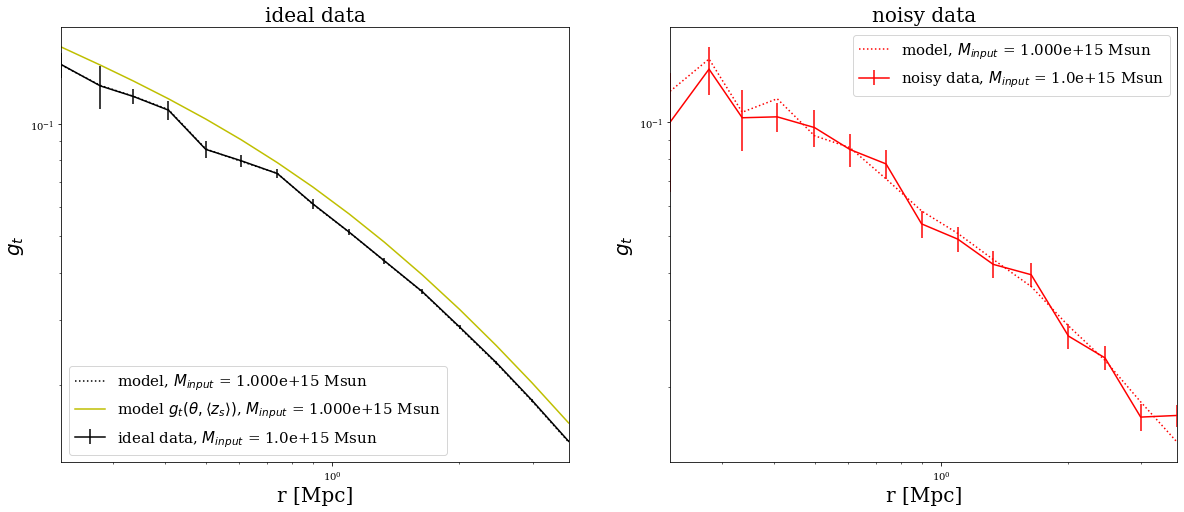

In [20]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)

plt.title('ideal data', fontsize=20)
plt.errorbar(r,profile_ideal['gt'],profile_ideal['gt_err'],c='k',fmt='-', label=r'ideal data, $M_{input}$ = %.1e Msun' % cluster_m)
plt.loglog(r,gt_model_ideal,':k',  label='model, $M_{input}$ = %.3e Msun' % cluster_m)
plt.loglog(r,gt_model,'-y',  label=r'model $g_t(\theta, \langle z_s\rangle)$, $M_{input}$ = %.3e Msun' % cluster_m)
plt.xlabel('r [Mpc]', fontsize = 20)
plt.ylabel(r'$g_t$', fontsize = 20)
plt.xlim(min(profile_ideal['radius']), max(profile_ideal['radius']))
plt.legend(fontsize = 15)

plt.subplot(1,2,2)

plt.title('noisy data', fontsize=20)
plt.errorbar(r,profile_noisy['gt'],profile_noisy['gt_err'],c='r',fmt='-', label=r'noisy data, $M_{input}$ = %.1e Msun' % cluster_m)
plt.loglog(r,gt_model_noisy,':r', label='model, $M_{input}$ = %.3e Msun' % cluster_m)
plt.xlabel('r [Mpc]', fontsize = 20)
plt.ylabel(r'$g_t$', fontsize = 20)
plt.xlim(min(profile_ideal['radius']), max(profile_ideal['radius']))
plt.legend(fontsize = 15)

# Fitting a halo mass - taking account for the source redshift distribution in the model

We estimate the best-fit mass using `scipy.optimize.curve_fit`.  We compare estimated mass for noisy and ideal data, moreover we estimate the halo mass considering $g_t(\theta, \langle z_s\rangle)$ that consists in the biaised approach.

In [21]:
popt,pcov = fitters['curve_fit'](lambda r, logm:predict_reduced_tangential_shear_Chang(r, logm, ideal_data, cl_ideal, profile_ideal), 
                        profile_ideal['radius'], 
                        profile_ideal['gt'], 
                        profile_ideal['gt_err'], bounds=[10.,16.])

m_est_ideal = 10.**popt[0]
m_est_err_ideal =  m_est_ideal * np.sqrt(pcov[0][0]) * np.log(10) 

popt,pcov = fitters['curve_fit'](lambda r, logm:predict_reduced_tangential_shear(r, logm, np.mean(profile_ideal['z'])), 
                        profile_ideal['radius'], 
                        profile_ideal['gt'], 
                        profile_ideal['gt_err'], bounds=[10.,17.])

m_est = 10.**popt[0]
m_est_err =  m_est * np.sqrt(pcov[0][0]) * np.log(10) 


popt,pcov = fitters['curve_fit'](lambda r, logm:predict_reduced_tangential_shear_Chang(r, logm, noisy_data, cl_noisy, profile_noisy), 
                        profile_noisy['radius'], 
                        profile_noisy['gt'], 
                        profile_noisy['gt_err'], bounds=[10.,16.])

m_est_noisy = 10.**popt[0]
m_est_err_noisy =  m_est_noisy * np.sqrt(pcov[0][0]) * np.log(10) 

In [22]:
print(f'Best fit mass for ideal data = {m_est_ideal:.2e} +/- {m_est_err_ideal:.2e} Msun')
print(f'Best fit mass for noisy data = {m_est_noisy:.2e} +/- {m_est_err_noisy:.2e} Msun')
print(' ')
print(f'Best fit mass for biaised shear model = {m_est:.2e} +/- {m_est_err:.2e} Msun')

Best fit mass for ideal data = 1.01e+15 +/- 5.03e+11 Msun
Best fit mass for noisy data = 9.88e+14 +/- 3.24e+13 Msun
 
Best fit mass for biaised shear model = 8.60e+14 +/- 3.38e+12 Msun


# Visualization of the results

For visualization purpose, we calculate the reduced tangential shear predicted by the model with estimated masses fornoisy and ideal data.

In [23]:
gt_est_ideal = predict_reduced_tangential_shear_Chang(r,np.log(m_est_ideal)/np.log(10), ideal_data, cl_ideal, profile_ideal)
gt_est_noisy = predict_reduced_tangential_shear_Chang(r,np.log(m_est_noisy)/np.log(10), noisy_data, cl_noisy, profile_noisy)
gt_est = predict_reduced_tangential_shear(r,np.log(m_est)/np.log(10), z_average)


We compare to tangential shear obtained with theoretical mass.

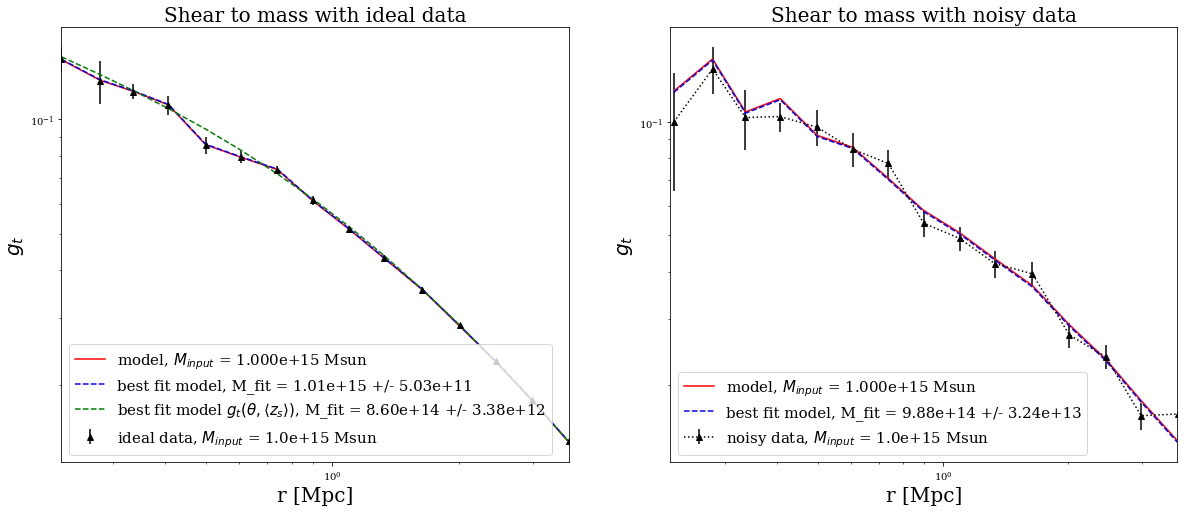

In [24]:
plt.figure(figsize=( 20 , 8 ))
plt.subplot( 1 , 2 , 1 )
plt.title('Shear to mass with ideal data', fontsize=20)
plt.errorbar(r,profile_ideal['gt'],profile_ideal['gt_err'],c='k',fmt='^', label=r'ideal data, $M_{input}$ = %.1e Msun' % cluster_m)
plt.loglog(r,gt_model_ideal,'-r',  label='model, $M_{input}$ = %.3e Msun' % cluster_m)
plt.loglog(r,gt_est_ideal,'--b', label='best fit model, M_fit = %.2e +/- %.2e' % (m_est_ideal, m_est_err_ideal))
plt.loglog(r,gt_est,'--g', label=r'best fit model $g_t(\theta,\langle z_s \rangle)$, M_fit = %.2e +/- %.2e' % (m_est, m_est_err))


plt.xlabel('r [Mpc]', fontsize = 20)
plt.ylabel(r'$g_t$', fontsize = 20)
plt.xlim(min(profile_ideal['radius']), max(profile_ideal['radius']))
plt.legend(fontsize = 15)


plt.subplot( 1 , 2 , 2 )
plt.title('Shear to mass with noisy data', fontsize=20)
plt.errorbar(r,profile_noisy['gt'],profile_noisy['gt_err'],c='k',fmt=':^', label=r'noisy data, $M_{input}$ = %.1e Msun' % cluster_m)
plt.loglog(r,gt_model_noisy,'-r',  label='model, $M_{input}$ = %.3e Msun' % cluster_m)
plt.loglog(r,gt_est_noisy,'--b', label='best fit model, M_fit = %.2e +/- %.2e' % (m_est_noisy, m_est_err_noisy))

plt.xlabel('r [Mpc]', fontsize = 20)
plt.ylabel(r'$g_t$', fontsize = 20)
plt.xlim(min(profile_noisy['radius']), max(profile_noisy['radius']))
plt.legend(fontsize = 15)

We note that estimated mass by fitting the biaised model is uncorrect.

In [25]:
print(f'Best fit mass for biaised shear model = {m_est:.2e} +/- {m_est_err:.2e} Msun')

Best fit mass for biaised shear model = 8.60e+14 +/- 3.38e+12 Msun
